In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter, PercentFormatter
import seaborn as sns
import numpy as np
import os
import math
from scipy import stats

ModuleNotFoundError: No module named 'scipy'

In [3]:
sns.set()
sns.set_palette('pastel')

## Helpers

In [4]:
def rssi2meters(rssi, tx=-59, N=2):
  return 10 ** (-(rssi - tx) / (10 * N))

In [5]:
def meters2rssi(meters, tx=-59, N=2):
    return -10 * N * math.log10(meters) + tx

In [6]:
class KalmanFilter:
    def __init__(self, process_noise=0.1, sensor_noise=3.5, estimated_error=0, value=None):
        self.process_noise = process_noise
        self.sensor_noise = sensor_noise
        self.estimated_error = estimated_error
        self.prediction_cycles = 0
        self.value = value
        
    def get_filtered_value(self, measurement):
        # prediction phase
        self.estimated_error += self.process_noise
        
        if self.value is None:
            self.value = measurement
        
        # measurement update
        kalman_gain = self.estimated_error / (self.estimated_error + self.sensor_noise)
        self.value = self.value + kalman_gain * (measurement - self.value)
        self.estimated_error = (1 - kalman_gain) * self.estimated_error
        
        return self.value

## Raw Analysis

In [7]:
poi_x, poi_y = (2,5)
close_dist = 1.5
far_dist = 6
data_dir = 'data/exp1-distance'

In [8]:
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

In [9]:
dfs = [
    pd.read_csv(os.path.join(data_dir, csv), parse_dates=['time']).assign(dataset_index=i + 1)
    for i, csv in enumerate(csv_files)
]
size = len(dfs)
size

3

In [10]:
dfc_all = []
for i, df in enumerate(dfs):
    df['experiment'] = i

    # Step time
    step_times = [
        df[df['xp_step'] == s]['time'].iloc[0]
        for s
        in range(0, max(df['xp_step']+1))
    ]
    step_times.append(max(df['time']))

    # Cleaning
    df = df[(df['xp_step'] >= 0)].reset_index(drop=True)

    for i in range(1, size+1):
        df[f'ESP32-{i}_new_raw_dist'] = [rssi2meters(v, tx=beacons_tx[i-1, N=beacons_n[i-1]) for v in df[f'ESP32-{i}_rssi']]
        
        kf = KalmanFilter()
        df[f'ESP32-{i}_filtered_rssi'] = df[f'ESP32-{i}_rssi'].apply(lambda x: kf.get_filtered_value(x))
        
        kf = KalmanFilter()
        df[f'ESP32-{i}_old_filtered_dist'] = df[f'ESP32-{i}_raw_dist'].apply(lambda x: kf.get_filtered_value(x))
        
        kf = KalmanFilter()
        df[f'ESP32-{i}_new_filtered_dist'] = df[f'ESP32-{i}_new_raw_dist'].apply(lambda x: kf.get_filtered_value(x))

    # Intermediate steps cleaning
    df = df[df['xp_step'] % 2 == 0].reset_index(drop=True)

    # Theory
    theorical_positions = []

    for i, row in df.iterrows():
        theorical_positions.append((row['xp_step'] // 2, 0))
        
    df['theorical_x'], df['theorical_y'] = np.array(theorical_positions).T

    dfc_all.append(df)
dfc = pd.concat(dfc_all)

NameError: name 'beacons_tx' is not defined

In [11]:
beacons_positions = {1: (0, 0), 2: (0, 0), 3: (0,0)}

In [23]:
for i in range(1, size+1):
    dfc[f'ESP32-{i}_theorical_dist'] = ((dfc['theorical_x']-beacons_positions[i][0])**2+(dfc['theorical_y']-beacons_positions[i][1])**2)**0.5
    dfc[f'ESP32-{i}_error_raw_dist'] = abs(dfc[f'ESP32-{i}_theorical_dist']-dfc[f'ESP32-{i}_raw_dist'])
    dfc[f'ESP32-{i}_error_filtered_dist'] = abs(dfc[f'ESP32-{i}_theorical_dist']-dfc[f'ESP32-{i}_filtered_dist'])
    dfc[f'ESP32-{i}_error_new_dist'] = abs(dfc[f'ESP32-{i}_theorical_dist']-dfc[f'ESP32-{i}_new_raw_dist'])
    dfc[f'ESP32-{i}_error_new_filtered_dist'] = abs(dfc[f'ESP32-{i}_theorical_dist']-dfc[f'ESP32-{i}_new_filtered_dist'])

In [24]:
# Create a list to hold the dataframes for each ESP32
dfs_list = []

for i in range(1, size+1):
    # Select columns for this ESP32
    cols = [
        f'ESP32-{i}_rssi',
        f'ESP32-{i}_filtered_rssi',
        f'ESP32-{i}_theorical_dist',
        f'ESP32-{i}_error_raw_dist',
        f'ESP32-{i}_error_filtered_dist',
        f'ESP32-{i}_error_new_dist',
        f'ESP32-{i}_error_new_filtered_dist',
        f'ESP32-{i}_raw_dist',
        f'ESP32-{i}_new_raw_dist',
        f'ESP32-{i}_filtered_dist',
        f'ESP32-{i}_new_filtered_dist',
        'experiment',
    ]
    
    # Create a dataframe with only the rows where this ESP32's RSSI is not null
    df_esp = dfc[cols].rename(
        columns={
            f'ESP32-{i}_rssi': 'rssi',
            f'ESP32-{i}_filtered_rssi': 'filtered_rssi',
            f'ESP32-{i}_theorical_dist': 'theorical_dist',
            f'ESP32-{i}_error_raw_dist': 'error_raw_dist',
            f'ESP32-{i}_error_filtered_dist': 'error_filtered_dist',
            f'ESP32-{i}_error_new_dist': 'error_new_dist',
            f'ESP32-{i}_error_new_filtered_dist': 'error_new_filtered_dist',
            f'ESP32-{i}_raw_dist': 'raw_dist',
            f'ESP32-{i}_new_raw_dist': 'new_raw_dist',
            f'ESP32-{i}_filtered_dist': 'filtered_dist',
            f'ESP32-{i}_new_filtered_dist': 'new_filtered_dist',
        }
    )
    
    # Only keep rows where RSSI is not null
    df_esp = df_esp.dropna(subset=['rssi']).copy()
    
    # Add beacon identifier
    df_esp['beacon'] = i
    
    # Add to list if there are any valid rows
    if not df_esp.empty:
        dfs_list.append(df_esp)

# Concatenate all the dataframes
dft = pd.concat(dfs_list, ignore_index=True)

In [25]:
palette = sns.color_palette('pastel', n_colors=size)

## RSSI@1m

In [48]:
# plt.figure(figsize=(10,5))
# plt.subplots_adjust(bottom=0.13, top=0.94, left=0.05, right=0.95)
# rssi_at_1m = dft[dft['theorical_dist'] == 1.0]
# plt.title('RSSI count per value at 1m')

# # Create histogram with beacon hue
# ax = sns.histplot(x=rssi_at_1m['rssi'], discrete=True, hue=rssi_at_1m['beacon'], 
#                  palette='pastel', stat='probability', common_norm=False)

# # Get the unique beacons and the color palette
# beacons = rssi_at_1m['beacon'].unique()

# beacons_tx = []

# # Add vertical lines for the mean of each beacon
# for beacon in beacons:
#     beacon_data = rssi_at_1m[rssi_at_1m['beacon'] == beacon]
#     beacon_mean = beacon_data['rssi'].mean()
#     beacon_color = palette[beacon-1]
#     beacons_tx.append(beacon_mean)
#     ax.axvline(x=beacon_mean, color=beacon_color, linestyle='--', 
#               linewidth=2, label=f'Mean beacon {beacon}: {beacon_mean:.2f}')

# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.legend(loc='best', fontsize='small')
# plt.savefig('out/beacon-rssi-1m.pdf')

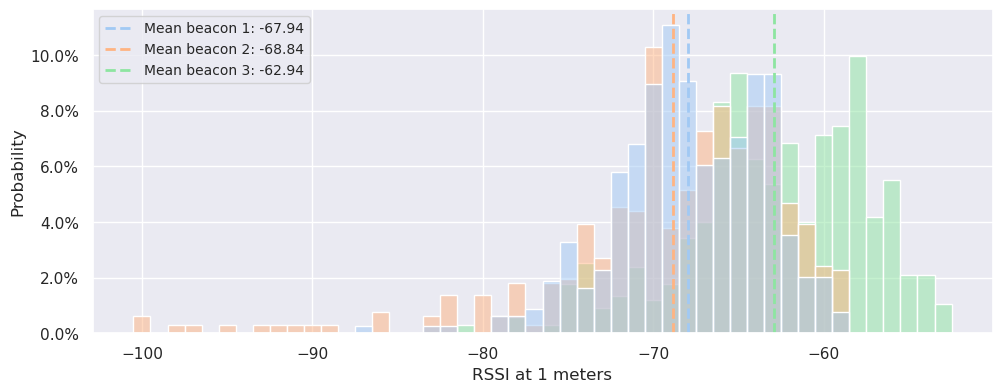

In [52]:
dft['estimated_tx'] = dft.T.apply(lambda row: 10 * 2 * math.log10(row['theorical_dist']) + row['rssi'] if row['theorical_dist'] > 0 else None)
plt.figure(figsize=(10, 4))
plt.subplots_adjust(bottom=0.13, top=0.94, left=0.05, right=0.95)
ax = sns.histplot(data=dft, x='estimated_tx', hue='beacon', palette='pastel', discrete=True, stat='probability', common_norm=False)

beacons_tx = []

for i in range(1, size+1):
    mean = dft[dft['beacon'] == i]['estimated_tx'].mean()
    color = palette[i-1]
    ax.axvline(x=mean, color=color, linestyle='--', linewidth=2, label=f'Mean beacon {i}: {mean:.2f}')
    beacons_tx.append(mean)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='best', fontsize='small')
plt.xlabel('RSSI at 1 meters')
plt.savefig('out/beacon-rssi-1m.pdf')

## Comparison of Environmentals Factors (N) in RSSI-Distance Conversion Model

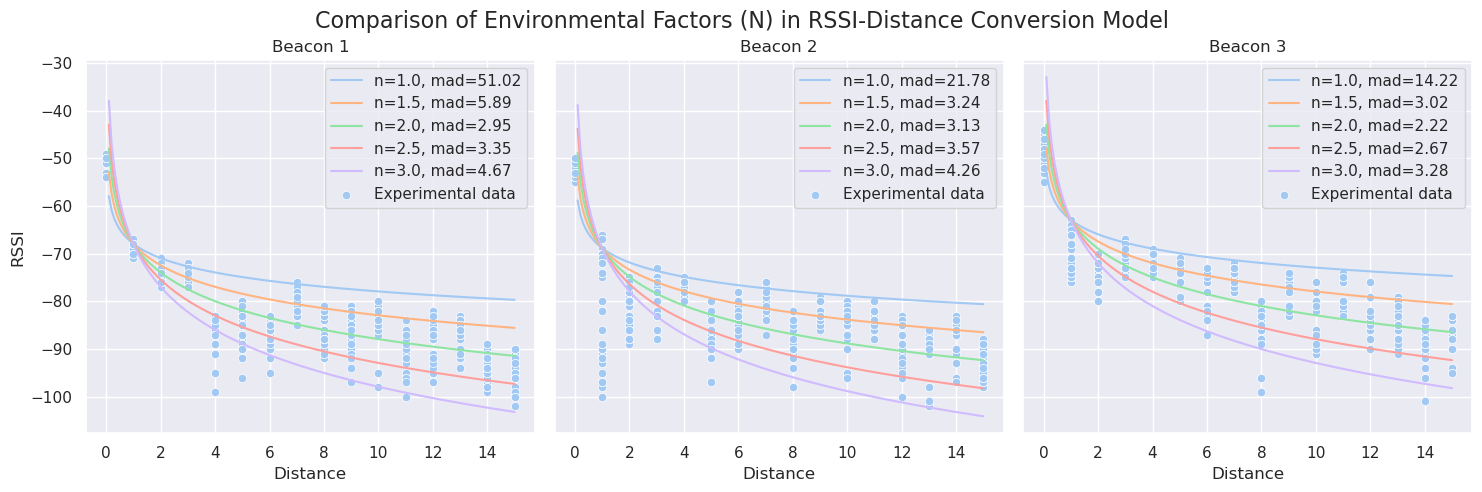

In [29]:
# Create a single figure with subplots side by side
fig, axes = plt.subplots(1, size, figsize=(5*size, 5), sharey=True)
fig.suptitle('Comparison of Environmental Factors (N) in RSSI-Distance Conversion Model', fontsize=16)

# If size is 1, axes will not be an array, so convert it to one for consistent indexing
if size == 1:
    axes = [axes]

beacons_n = []

for i in range(size):
    tx = beacons_tx[i]
    ax = axes[i]

    best_n = (None, None)
    
    # Plot data for each environmental factor
    for n in np.arange(1.0, 3.1, 0.5):
        xv = np.arange(0.1, 15.1, 0.1)
        yv = [meters2rssi(v, tx=tx, N=n) for v in xv]
        MAD = np.median([
            abs(
                rssi2meters(
                    row['rssi'],
                    tx=tx,
                    N=n
                )
                -
                row['theorical_dist']
            )
            for idx, row in dft.iterrows()
            if row['theorical_dist'] > 0
            if row['beacon'] == i+1
        ])
        
        sns.lineplot(x=xv, y=yv, label=f'n={n}, mad={MAD:.2f}', ax=ax)

        if best_n[0] is None or MAD < best_n[0]:
            best_n = (MAD, n)

    beacons_n.append(best_n[1])
    
    # Plot experimental data
    beacon_data = dft[dft['beacon'] == i+1]
    sns.scatterplot(data=beacon_data, x='theorical_dist', y='rssi', label='Experimental data', ax=ax)
    
    # Set subplot title and labels
    ax.set_title(f'Beacon {i+1}')
    ax.set_xlabel('Distance')
    
    # Only set y-label for the first subplot
    if i == 0:
        ax.set_ylabel('RSSI')
    else:
        ax.set_ylabel('')

# Adjust layout to prevent overlap
plt.tight_layout()
fig.subplots_adjust(top=0.88)  # Make room for the suptitle

plt.savefig('out/beacon-environmental-factor.pdf', bbox_inches='tight')

## Evolution of the Raw Distance Error relative to the Distance to Beacons

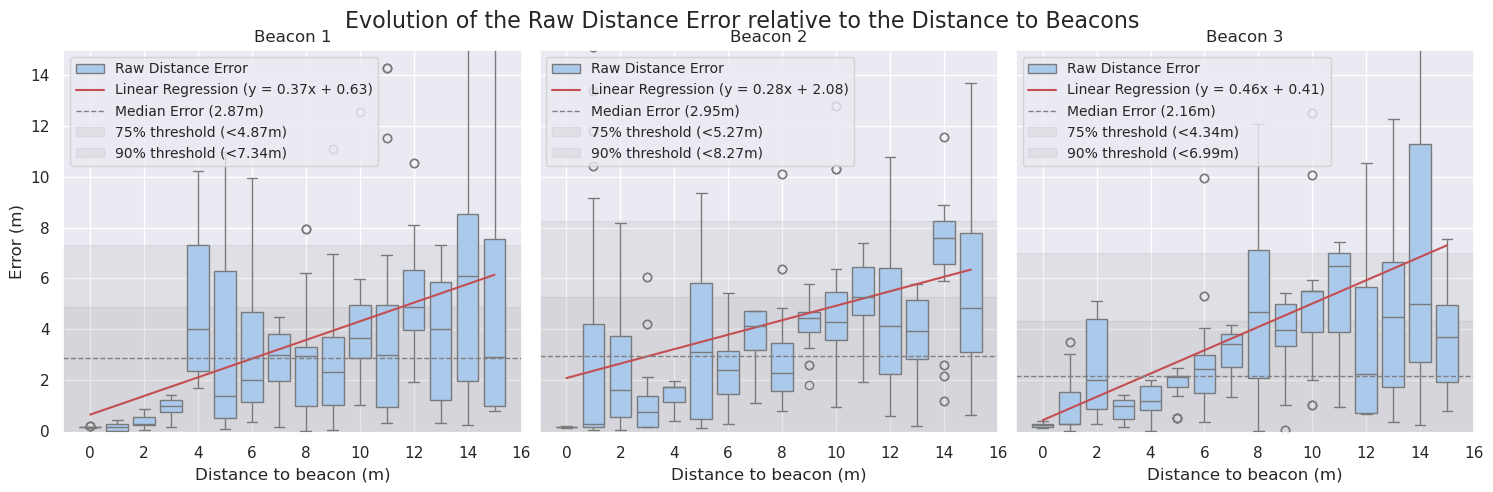

In [56]:
fig, axes = plt.subplots(1, size, figsize=(5*size, 5), sharey=True)
fig.suptitle('Evolution of the Raw Distance Error relative to the Distance to Beacons', fontsize=16)

if size == 1:
    axes = [axes]

for i in range(size):
    ax = axes[i]
    sub_dft = dft[dft['beacon'] == i+1]
    
    sns.boxplot(data=sub_dft, x='theorical_dist', y='error_new_dist', 
                native_scale=True, label='Raw Distance Error', ax=ax)
    
    x = sub_dft['theorical_dist']
    y = sub_dft['error_new_dist']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    x_reg = np.array([min(x), max(x)])
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, 'r-', label=f'Linear Regression (y = {slope:.2f}x + {intercept:.2f})')
    
    median = sub_dft['error_new_dist'].median()
    ax.axhline(y=median, ls='--', c='gray', lw=1, 
               label=f'Median Error ({median:.2f}m)')
    
    confid = 0.75
    confid_max = np.percentile(sub_dft['error_new_dist'], 100 * confid)
    ax.fill_between([sub_dft['theorical_dist'].min()-1, sub_dft['theorical_dist'].max()+1], 
                    0, confid_max, color='gray', alpha=0.1, 
                    label=f'{confid:.0%} threshold (<{confid_max:.2f}m)')
    
    confid = 0.9
    confid_max = np.percentile(sub_dft['error_new_dist'], 100 * confid)
    ax.fill_between([sub_dft['theorical_dist'].min()-1, sub_dft['theorical_dist'].max()+1], 
                    0, confid_max, color='gray', alpha=0.1, 
                    label=f'{confid:.0%} threshold (<{confid_max:.2f}m)')
    
    ax.set_title(f'Beacon {i+1}')
    ax.set_xlabel('Distance to beacon (m)')
    
    # Only set y-label for the first subplot
    if i == 0:
        ax.set_ylabel('Error (m)')
    else:
        ax.set_ylabel('')
    
    ax.set_ylim((-0.1, 15))
    ax.set_xlim((sub_dft['theorical_dist'].min()-1, sub_dft['theorical_dist'].max()+1))
    
    ax.legend(fontsize='small', loc='upper left')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.9)

plt.savefig('out/beacon-dist-raw-error-by-beacon.pdf', bbox_inches='tight')

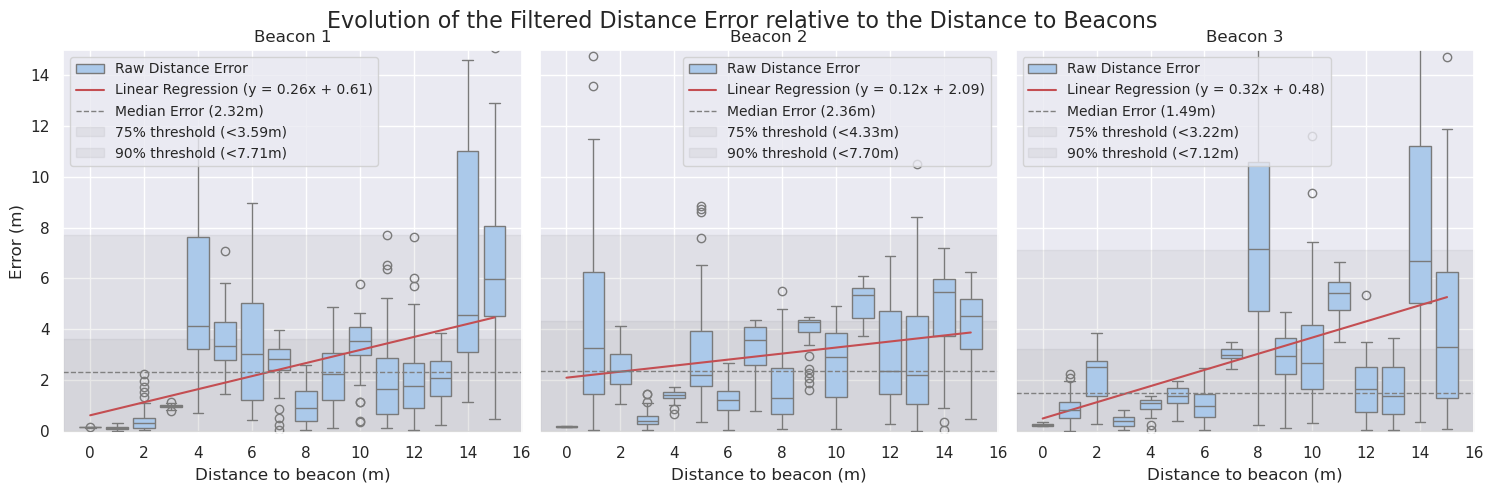

In [57]:
fig, axes = plt.subplots(1, size, figsize=(5*size, 5), sharey=True)
fig.suptitle('Evolution of the Filtered Distance Error relative to the Distance to Beacons', fontsize=16)

if size == 1:
    axes = [axes]

for i in range(size):
    ax = axes[i]
    sub_dft = dft[dft['beacon'] == i+1]
    
    sns.boxplot(data=sub_dft, x='theorical_dist', y='error_new_filtered_dist', 
                native_scale=True, label='Raw Distance Error', ax=ax)
    
    x = sub_dft['theorical_dist']
    y = sub_dft['error_new_filtered_dist']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    x_reg = np.array([min(x), max(x)])
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, 'r-', label=f'Linear Regression (y = {slope:.2f}x + {intercept:.2f})')
    
    median = sub_dft['error_new_filtered_dist'].median()
    ax.axhline(y=median, ls='--', c='gray', lw=1, 
               label=f'Median Error ({median:.2f}m)')
    
    confid = 0.75
    confid_max = np.percentile(sub_dft['error_new_filtered_dist'], 100 * confid)
    ax.fill_between([sub_dft['theorical_dist'].min()-1, sub_dft['theorical_dist'].max()+1], 
                    0, confid_max, color='gray', alpha=0.1, 
                    label=f'{confid:.0%} threshold (<{confid_max:.2f}m)')
    
    confid = 0.9
    confid_max = np.percentile(sub_dft['error_filtered_dist'], 100 * confid)
    ax.fill_between([sub_dft['theorical_dist'].min()-1, sub_dft['theorical_dist'].max()+1], 
                    0, confid_max, color='gray', alpha=0.1, 
                    label=f'{confid:.0%} threshold (<{confid_max:.2f}m)')
    
    ax.set_title(f'Beacon {i+1}')
    ax.set_xlabel('Distance to beacon (m)')
    
    # Only set y-label for the first subplot
    if i == 0:
        ax.set_ylabel('Error (m)')
    else:
        ax.set_ylabel('')
    
    ax.set_ylim((-0.1, 15))
    ax.set_xlim((sub_dft['theorical_dist'].min()-1, sub_dft['theorical_dist'].max()+1))
    
    ax.legend(fontsize='small', loc='best')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.9)

plt.savefig('out/beacon-dist-filtered-error-by-beacon.pdf', bbox_inches='tight')

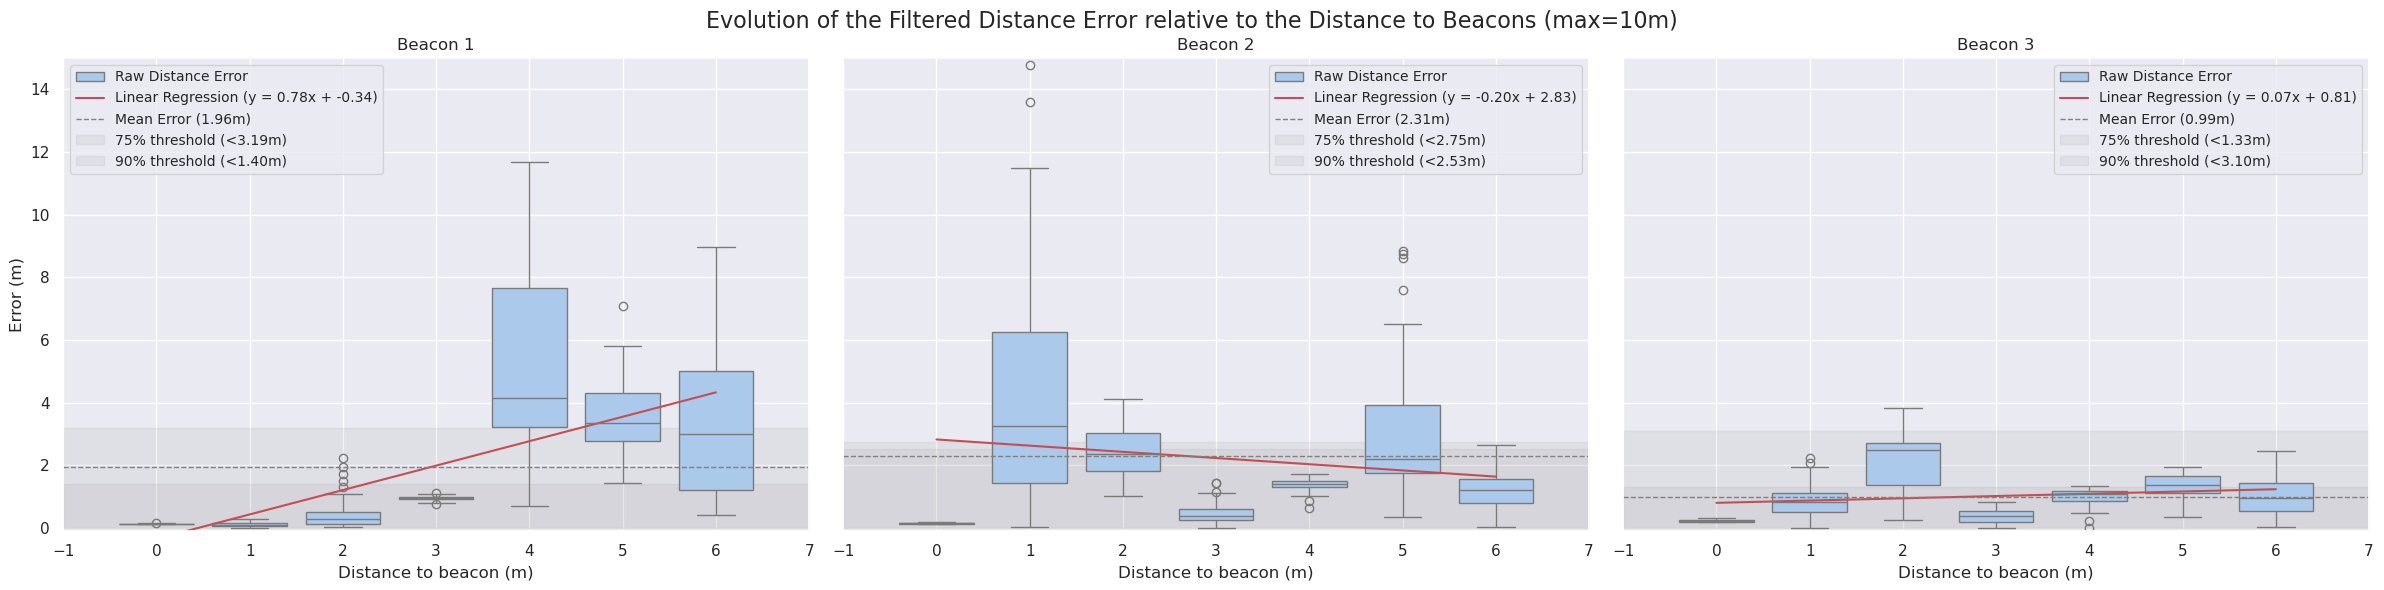

In [46]:
fig, axes = plt.subplots(1, size, figsize=(5*size, 5), sharey=True)
fig.suptitle('Evolution of the Filtered Distance Error relative to the Distance to Beacons (max=10m)', fontsize=16)

if size == 1:
    axes = [axes]

for i in range(size):
    ax = axes[i]
    sub_dft = dft[(dft['beacon'] == i+1) & (dft['theorical_dist'] <= 6)]
    
    sns.boxplot(data=sub_dft, x='theorical_dist', y='error_new_filtered_dist', 
                native_scale=True, label='Raw Distance Error', ax=ax)
    
    x = sub_dft['theorical_dist']
    y = sub_dft['error_new_filtered_dist']
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    x_reg = np.array([min(x), max(x)])
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, 'r-', label=f'Linear Regression (y = {slope:.2f}x + {intercept:.2f})')
    
    mean_error = sub_dft['error_new_filtered_dist'].mean()
    ax.axhline(y=mean_error, ls='--', c='gray', lw=1, 
               label=f'Mean Error ({mean_error:.2f}m)')
    
    confid = 0.75
    confid_max = np.percentile(sub_dft['error_new_filtered_dist'], 100 * confid)
    ax.fill_between([sub_dft['theorical_dist'].min()-1, sub_dft['theorical_dist'].max()+1], 
                    0, confid_max, color='gray', alpha=0.1, 
                    label=f'{confid:.0%} threshold (<{confid_max:.2f}m)')
    
    confid = 0.9
    confid_max = np.percentile(sub_dft['error_filtered_dist'], 100 * confid)
    ax.fill_between([sub_dft['theorical_dist'].min()-1, sub_dft['theorical_dist'].max()+1], 
                    0, confid_max, color='gray', alpha=0.1, 
                    label=f'{confid:.0%} threshold (<{confid_max:.2f}m)')
    
    ax.set_title(f'Beacon {i+1}')
    ax.set_xlabel('Distance to beacon (m)')
    
    # Only set y-label for the first subplot
    if i == 0:
        ax.set_ylabel('Error (m)')
    else:
        ax.set_ylabel('')
    
    ax.set_ylim((-0.1, 15))
    ax.set_xlim((sub_dft['theorical_dist'].min()-1, sub_dft['theorical_dist'].max()+1))
    
    ax.legend(fontsize='small', loc='best')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.9)

# plt.savefig('out/beacon-dist-filtered-error-by-beacon.pdf', bbox_inches='tight')

## Other

<Axes: xlabel='None', ylabel='rssi'>

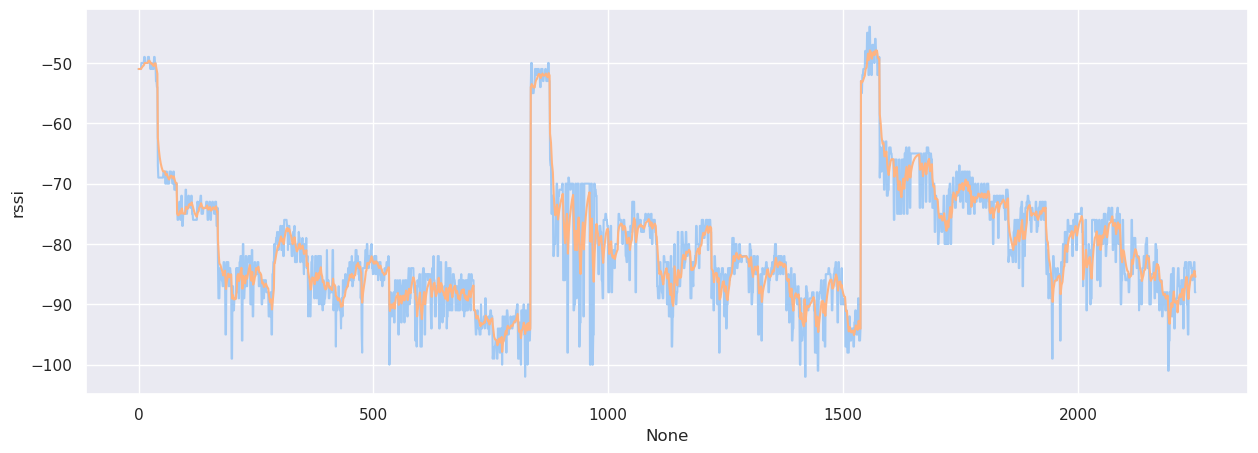

In [31]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dft, x=dft.index, y='rssi')
sns.lineplot(data=dft, x=dft.index, y='filtered_rssi')

<Axes: xlabel='None', ylabel='new_raw_dist'>

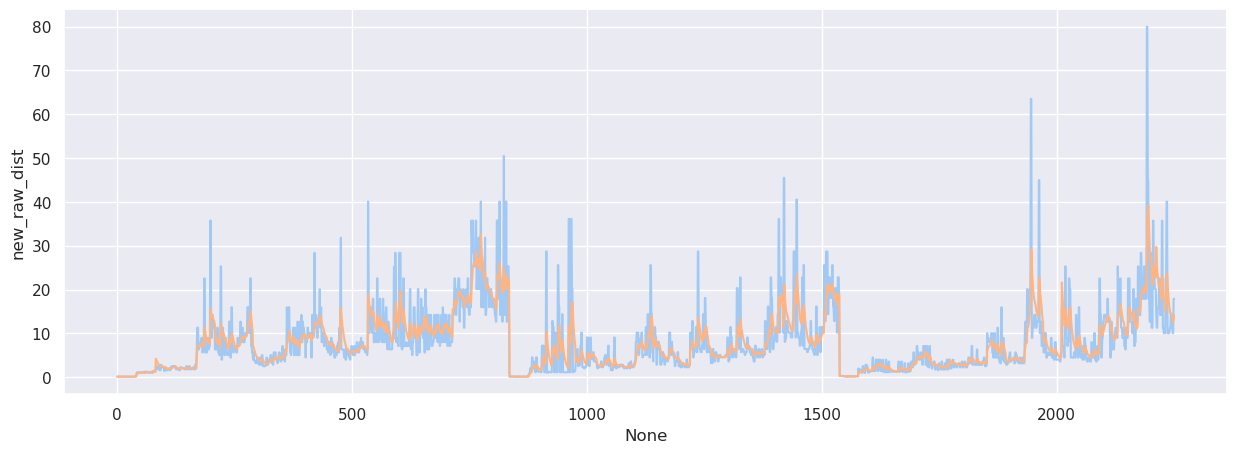

In [32]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=dft, x=dft.index, y='new_raw_dist')
sns.lineplot(data=dft, x=dft.index, y='new_filtered_dist')